# Figures for Yarkoni & Westfall (2016)
This notebook contains Python code to generate all the figures included in Yarkoni & Westfall (2016) -- "Choosing prediction over explanation in psychology: Lessons from machine learning."

In [1]:
# Import all the things
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, scale
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest
import matplotlib.gridspec as gridspec
import matplotlib
import math
%matplotlib inline

/Users/tal/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# Figure 1

/Users/tal/anaconda/lib/python3.5/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


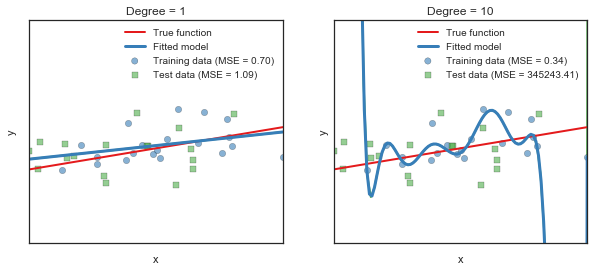

In [2]:
sns.set_style("white")
def plot_true_fx_with_sample(func, degrees=[1,2,10], train_range=(-2, 2), n=20, show_training=True, 
                             show_testing=False, show_true=True, show_model=True, show_fit_text=True,
                             test_range=None, seed=None, reps=None):
    
    if test_range is None: test_range = train_range
    
    if seed is not None:
        np.random.seed(seed)
        
    def get_X(x_min, x_max): return np.random.uniform(x_min, x_max, (n,1))
    get_y = lambda x: func(x) + np.random.normal(size=(n,1))
    
    X = np.random.normal(size=(n,1))
    y = get_y(X)
    
    colors = sns.color_palette('Set1', 3)
    
    n_degrees = len(degrees)
    
    fig, axes = plt.subplots(1, n_degrees, sharex=True, sharey=True, figsize=(n_degrees*5, 4))
    x_min, x_max = X.min(), X.max()
    
    if show_testing:
        test_X = get_X(*test_range)
        test_y = get_y(test_X)
        x_min, x_max = min(x_min, test_X.min()), min(x_max, test_X.max())
        
    plt.xlim((x_min, x_max))
    plt.ylim((-4, 8))
        
    for i in range(n_degrees):
        ax = axes[i]
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        polynomial_features = PolynomialFeatures(degree=degrees[i], include_bias=False)
        linear_regression = LinearRegression()
        pipeline = Pipeline([("polynomial_features", polynomial_features),
                             ("linear_regression", linear_regression)])
        Xp = np.hstack((X, np.ones_like(X)))
        pipeline.fit(Xp, y)

        plt.sca(ax)
        
        if show_true:
            lin_x = np.linspace(x_min, x_max, 100)[:,None]
            lin_x = np.linspace(x_min, x_max, num=100)[:,None]
            plt.plot(lin_x, func(lin_x), label="True function", c=colors[0], lw=2, ls='-')

        if show_model:
            plt.plot(lin_x, pipeline.predict(np.hstack((lin_x, np.ones_like(lin_x)))), label="Fitted model", c=colors[1], lw=3, ls='-')
            
        if show_training:
            label = "Training data"
            if show_fit_text: 
                label += " (MSE = %.2f)" % mean_squared_error(y, pipeline.predict(Xp))
            plt.scatter(X, y, label=label, c=colors[1], s=40, alpha=0.6)
            
        if show_testing:
            if show_model:
                lin_x = np.linspace(*test_range, num=100)[:,None]
                plt.plot(lin_x, pipeline.predict(np.hstack((lin_x, np.ones_like(lin_x)))), 
                         c=colors[2], zorder=-100, lw=2, ls='-')
            label = "Test data"
            if show_fit_text: 
                label += " (MSE = %.2f)" % mean_squared_error(test_y, pipeline.predict(np.hstack((test_X, np.ones_like(test_X)))))
            plt.scatter(test_X, test_y, label = label, c=colors[2], s=40, marker='s', alpha=0.6)
            
        if reps is not None:
            results = np.zeros((reps, 100))
            lin_x = np.linspace(*train_range, num=100)
            for r in range(reps):
                tX = get_X(*train_range)
                ty = get_y(tX)
                pipeline.fit(tX, ty)
                results[r] = pipeline.predict(lin_x[:,None]).ravel()
                plt.plot(lin_x, results[r], c=colors[1], zorder=-100, lw=1, ls='-', alpha=0.1)
            m = results.mean(axis=0)
            plt.plot(lin_x, pipeline.predict(lin_x[:,None]), c=colors[1], zorder=-100, lw=3, 
                     ls='-', alpha=1.0, label="Mean fit (%d samples)" % reps)
                
            
        plt.title("Degree = %d" % degrees[i])
                    
        plt.xlabel("x")
        plt.ylabel("y")

        plt.legend(loc="best")
        
    return fig
    
# True function
fx = lambda x: 0.8*x + 1.2

fig = plot_true_fx_with_sample(fx, n=20, degrees=[1, 10], seed=1000, 
                         show_model=True, show_true=True, show_training=True, show_testing=True,
                         reps=None)


# fig.savefig('/Users/tal/Downloads/overfitting_test.png', dpi=200, bbox_inches='tight')

# Figure 2
Illustration of bias vs. variance. An estimator’s predictions can deviate from the desired outcome (or true scores) in two ways. First, the predictions may display a systematic tendency (or bias) to deviate from the central tendency of the true scores (compare right panels with left panels). Second, the predictions may show a high degree of variance, or imprecision (compare bottom panels with top panels).

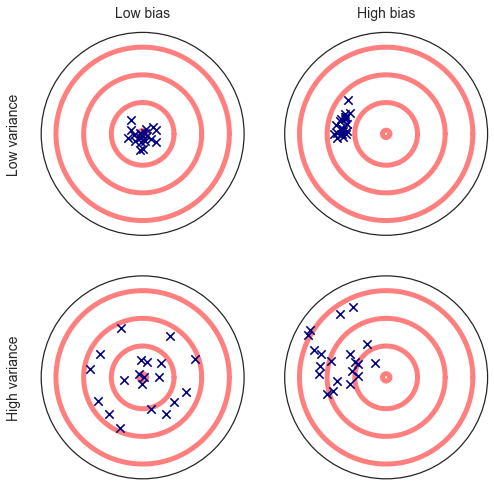

In [3]:
# Dartboard example
N_DARTS = 20
LABEL_SIZE = 14
import math
fig, axes = plt.subplots(2, 2, subplot_kw=dict(polar=True))
fig.set_size_inches((8, 8))
theta = np.linspace(0, 2*math.pi, 1000)

data = np.array([[
    # low-bias, low-variance
    [np.random.uniform(0, 2*math.pi, N_DARTS),
     np.random.uniform(0, 2, N_DARTS)], 
    # high-bias, low-variance
    [np.random.normal(3, 0.2, N_DARTS),
     np.random.normal(5, 0.5, N_DARTS)]],
    # low-bias, high-variance
    [[np.linspace(0, 2*math.pi, N_DARTS),
     np.random.uniform(0, 6, N_DARTS)],
    # high-bias, high-variance
    [np.random.normal(3, 0.5, N_DARTS),
     np.random.uniform(2, 9.8, N_DARTS)]
    ]])

for i in range(2):
    for j in range(2):
        ax = axes[i,j]
        for k in range(4):
            ax.plot(theta, np.ones_like(theta)*k*3+0.4, lw=5, c='red', alpha=0.5)
        ax.set_ylim(0, 11)
        ax.set_xticks([])
        ax.set_yticks([])
        x = data[i, j, 0, :]
        y = data[i, j, 1, :]
        ax.scatter(x, y, marker='x', c='navy', s=70, lw=1.6, zorder=100)
    axes[0,0].set_title('Low bias', fontsize=LABEL_SIZE)
    axes[0,1].set_title('High bias', fontsize=LABEL_SIZE)
    axes[0,0].set_ylabel('Low variance', fontsize=LABEL_SIZE, labelpad=20)
    axes[1,0].set_ylabel('High variance', fontsize=LABEL_SIZE, labelpad=20)

# Figure 3

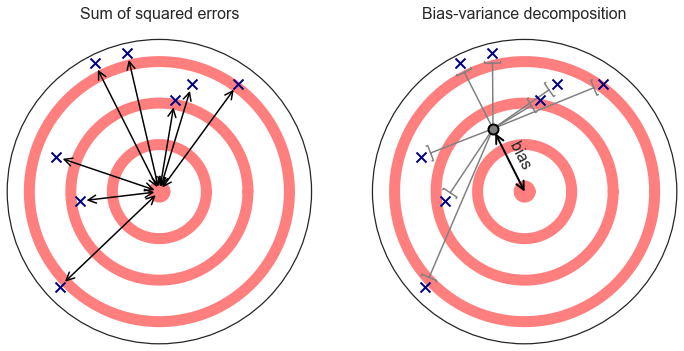

In [4]:
N_DARTS = 8

def cart2pol(x, y):
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    return(theta, r)

def pol2cart(theta, r):
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return(x, y)

def figure_4():
    fig, axes = plt.subplots(1, 2, subplot_kw=dict(polar=True))
    fig.set_size_inches((12, 6))
    theta = np.linspace(0, 2*math.pi, 1000)

    theta = np.random.normal(3, 1., N_DARTS)
    theta_seq = np.linspace(0, 2*math.pi, 1000)
    r = np.random.uniform(5, 10.5, N_DARTS)

    for i in range(2):
        ax = axes[i]
        for k in range(4):
            ax.plot(theta_seq, np.ones_like(theta_seq)*k*3+0.4, lw=11, c='red', alpha=0.5)
        ax.set_ylim(0, 11)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.scatter(theta, r, marker='x', c='navy', s=100, lw=2, zorder=100)


    mt = theta.mean()
    mr = r.mean()
    x, y = pol2cart(theta, r)
    mx, my = x.mean(), y.mean()
    mx, my = cart2pol(mx, my)
    dt = theta - mt
    dr = r - mr

    # sum of squares
    ax = axes[0]
    for i in range(N_DARTS):
        ax.annotate(
            '', xy=(theta[i], r[i]), xycoords='data',
            xytext=(0, 0), textcoords='data',
            arrowprops=dict(arrowstyle='<->', shrinkA=5, shrinkB=7, lw=1.5, mutation_scale=20))
    ax.set_title("Sum of squared errors", fontsize=16)

    # bias-variance decomposition
    ax = axes[1]
    ax.scatter(mx, my, marker='o', c='gray', s=100, lw=2, zorder=100)

    for i in range(N_DARTS):
        ax.annotate(
            '', xy=(theta[i], r[i]), xycoords='data',
            xytext=(mx, my), textcoords='data',
            arrowprops=dict(arrowstyle='-[', shrinkA=0, shrinkB=10, lw=1.5, color='gray', mutation_scale=8))

    ax.annotate(
        '', xy=(0, 0), xycoords='data',
        xytext=(mx, my), textcoords='data',
        arrowprops=dict(arrowstyle='<->', shrinkA=5, shrinkB=0, lw=2, mutation_scale=20))
    
    ax.text(2., 3.2, 'bias', fontsize=16, rotation=-63)
    ax.set_title('Bias-variance decomposition', fontsize=16)
    
    bv = len(theta)*np.sqrt(mt**2 + mr**2)**2 + np.sum(np.sqrt(dt**2 + dr**2)**2)
    ss = np.sum(np.sqrt(theta**2 + r**2)**2)
    np.testing.assert_almost_equal(bv, ss)
    
seed = 72580
np.random.seed(seed)
figure_4()
plt.show()

# Figure 4

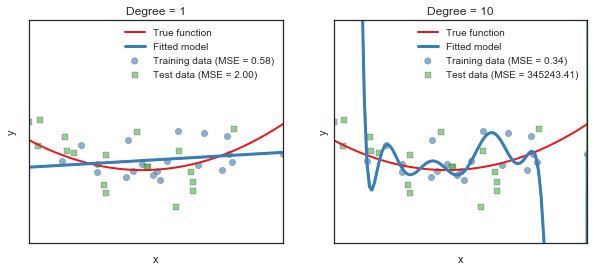

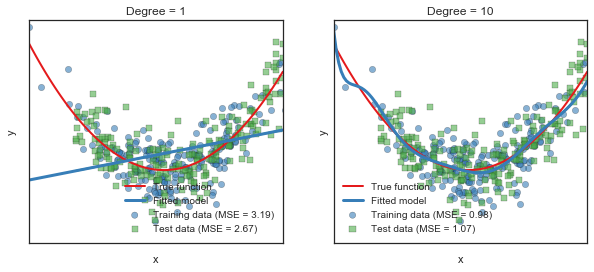

In [5]:
# True function
fx = lambda x: x**2 + 0.6*x

fig1 = plot_true_fx_with_sample(fx, n=20, degrees=[1, 10], seed=1000, 
                         show_model=True, show_true=True, show_training=True, show_testing=True,
                         reps=None)

fig2 = plot_true_fx_with_sample(fx, n=200, degrees=[1, 10], seed=1000, 
                         show_model=True, show_true=True, show_training=True, show_testing=True,
                         reps=None)


# Figure 5

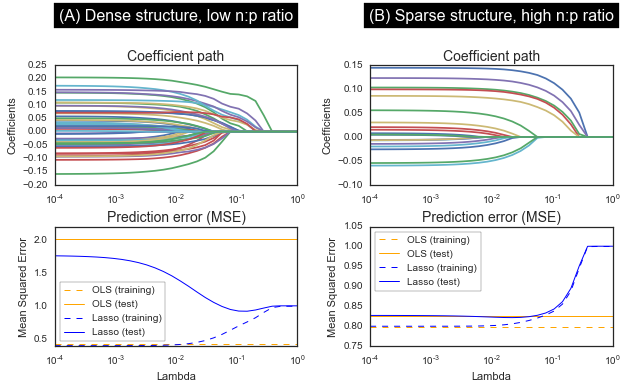

In [6]:
matplotlib.rc('font',**{'family':'sans-serif','sans-serif':['Arial']})
%matplotlib inline

# seed = np.random.randint(0, 10000)
seed = 6843
np.random.seed(seed)

def get_Xy(n, features, rx, ry=0., relevant=None):
    if relevant is None:
        relevant = features
    cov = np.zeros((features+1, features+1))
    # intercorrelations between X columns
    cov[:relevant, :relevant] = rx
    # correlation between x columns and y
    cov[:relevant, -1] = ry
    np.fill_diagonal(cov, 1.0)
    data = np.random.multivariate_normal([0.0]*(features+1), cov, n)
    X = data[:,:features]
    y = data[:,-1]
    return scale(X), scale(y)
    
def coef_path(axis, estimator, X, y, alpha):
    coefs = np.zeros((X.shape[1], len(alpha)))
    for (i, a) in enumerate(alpha):
        coefs[:,i] = estimator(alpha=a).fit(X, y).coef_
    axis.plot(alpha, coefs.T)
    axis.set_ylabel("Coefficients")
    axis.set_xscale('log')
    
def errors(axis, est, X, y, alpha, ols):
    
    ols_train_mse, ols_test_mse = ols
    
    from sklearn.learning_curve import validation_curve
    from sklearn.cross_validation import ShuffleSplit
    
    cv = ShuffleSplit(len(y), 50, 0.5)
    train_mse, test_mse = validation_curve(est(), X, y, 'alpha', alpha, cv=cv, scoring='mean_squared_error')
    axis.axhline(y=ols_train_mse, c='orange', ls='--', lw=1, label='OLS (training)')
    axis.axhline(y=ols_test_mse, c='orange', lw=1, label='OLS (test)')
    axis.plot(alpha, -train_mse.mean(1), c='blue', ls='--', lw=1, label='Lasso (training)')
    axis.plot(alpha, -test_mse.mean(1), c='blue', lw=1, label='Lasso (test)')
    axis.set_xlabel("Lambda")
    axis.set_ylabel("Mean Squared Error")
    axis.legend(loc='best', fontsize=10, frameon=True)
    axis.set_xscale('log')

def plot_col(gs, col, n, p, rx, ry=None, n_relevant=None,
             estimator=Lasso, alpha_bounds=None, title=''):
    
    if alpha_bounds is None:
        alpha_bounds = (-4, 0)
        
    alpha = np.logspace(*alpha_bounds, num=30)
    
    # Sample data
    X, y = get_Xy(n*2, p, rx, ry, n_relevant)

    # Calculate MSE for OLS for later
    est = LinearRegression()
    est.fit(X[:n], y[:n])
    ols_train_mse = mean_squared_error(y[:n], est.predict(X[:n]))
    ols_test_mse = mean_squared_error(y[n:], est.predict(X[n:]))

    # Row title
    box = dict(facecolor='black', pad=5)
    ax = plt.subplot(gs[0, col])
    ax.set_axis_off()
    ax.text(0.5, 0, title, fontsize=16, color='white', ha='center', va='bottom', bbox=box)
    
    # Coefficient paths
    ax = plt.subplot(gs[1, col])
    coef_path(ax, estimator, X, y, alpha)
    ax.set_title("Coefficient path", fontsize=14)
    
    # Lasso error
    ax = plt.subplot(gs[2, col])
    errors(ax, estimator, X, y, alpha, (ols_train_mse, ols_test_mse))
    ax.set_title("Prediction error (MSE)", fontsize=14)

    
rows = [
    [100, 50, 0.2, 0.2],
    [1000, 20, 0.5, 0.5, 5, Lasso],
    ]

titles = ['(A) Dense structure, low n:p ratio', '(B) Sparse structure, high n:p ratio']

n_rows = len(rows)
fig = plt.figure(figsize=(5*n_rows, 6))
gs = gridspec.GridSpec(3, n_rows, height_ratios=[1, 10, 10], hspace=0.5, wspace=0.3)

for i, r in enumerate(rows):
    plot_col(gs, i, *r, title=titles[i])

fig.savefig('Figure_5.png', dpi=200, bbox_inches='tight')